# ANALISE DE DADOS
---
## Dataset: br_inep_ideb_municipio

**Descri√ß√£o:**

O √çndice de Desenvolvimento da Educa√ß√£o B√°sica (Ideb), criado em 2007, mede a qualidade da educa√ß√£o no Brasil com base em dois fatores: fluxo escolar (aprova√ß√£o dos alunos) e desempenho nas avalia√ß√µes (Saeb e Prova Brasil). O √≠ndice, que varia de 0 a 10, busca equilibrar essas dimens√µes, garantindo que a melhoria do aprendizado n√£o ocorra √† custa da reten√ß√£o excessiva de alunos nem da aprova√ß√£o sem qualidade. Al√©m de ser um indicador de desempenho, o Ideb orienta pol√≠ticas p√∫blicas e acompanha as metas do Plano de Desenvolvimento da Educa√ß√£o (PDE), que estabeleceu a meta de alcan√ßar um Ideb 6,0 at√© 2022, n√≠vel compar√°vel ao de pa√≠ses desenvolvidos. 


**Importa√ß√£o das bibliotecas:**

In [38]:
# Importando bibliotecas necess√°rias
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Carregando dataset

In [39]:
# Carregando os dados da base CSV
try:
    caminho_arquivo = 'br_inep_ideb_municipio.csv'
    df = pd.read_csv(caminho_arquivo)

    # Exibindo as primeiras linhas no formato de tabela (usando display)
    from IPython.display import display  # Import necess√°rio para display no Jupyter Notebook
    display(df.head(10))  # Exibe as 10 primeiras linhas como uma tabela formatada

except FileNotFoundError:
    print(f"Erro: O arquivo '{caminho_arquivo}' n√£o foi encontrado. Verifique o caminho e tente novamente.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")


ano sigla_uf  id_municipio      rede ensino anos_escolares  \
0  2017       AC       1200054  estadual  medio    todos (1-4)   
1  2017       AL       2700706   publica  medio    todos (1-4)   
2  2017       AL       2705200  estadual  medio    todos (1-4)   
3  2017       AL       2700102   publica  medio    todos (1-4)   
4  2017       AL       2701407  estadual  medio    todos (1-4)   
5  2017       AL       2707701   publica  medio    todos (1-4)   
6  2017       AL       2701803   publica  medio    todos (1-4)   
7  2017       AL       2707107  estadual  medio    todos (1-4)   
8  2017       AL       2702108   publica  medio    todos (1-4)   
9  2017       AM       1301209   federal  medio    todos (1-4)   

   taxa_aprovacao  indicador_rendimento  nota_saeb_matematica  \
0            85.0              0.857865                263.23   
1            71.2              0.730771                256.25   
2            71.8              0.727002                251.36   
3            88.8              0.895662                245.11   
4            82.6              0.838620                248.35   
5            80.6              0.813259                252.03   
6            92.4              0.924909                247.25   
7            77.0              0.777787                251.41   
8            90.3              0.910204                256.17   
9            84.3              0.856874                272.88   

   nota_saeb_lingua_portuguesa  nota_saeb_media_padronizada  ideb  projecao  
0                       263.98                     4.338361   3.7       NaN  
1                       257.04                     4.136585   3.0       NaN  
2                       246.74                     3.913704   2.8       NaN  
3                       240.08                     3.726232   3.3       NaN  
4                       252.02                     3.950331   3.3       NaN  
5                       255.17                     4.049462   3.3       NaN  
6                       261.54                     4.077396   3.8       NaN  
7                       250.47                     3.970245   3.1       NaN  
8                       247.92                     3.999075   3.6       NaN  
9                       280.92                     4.727488   4.1       NaN

## Prepara√ß√£o do dataset

#### 1. Identificar os dados ausentes

In [40]:
missing_data = df.isnull().sum()  # Quantidade de valores ausentes por coluna
missing_percentage = (missing_data / len(df)) * 100  # Porcentagem de valores ausentes

# Criar um DataFrame para exibir o resumo dos dados ausentes
missing_summary = pd.DataFrame({
    "Coluna": df.columns,
    "Valores Ausentes": missing_data.values,
    "Percentual Ausente (%)": missing_percentage.values
}).sort_values(by="Percentual Ausente (%)", ascending=False)

# Exibe as colunas com dados ausentes
print("Resumo dos valores ausentes no dataset:")
display(missing_summary)

Resumo dos valores ausentes no dataset:


Coluna  Valores Ausentes  Percentual Ausente (%)
12                     projecao             91853               32.414282
11                         ideb             43258               15.265446
8          nota_saeb_matematica             43223               15.253095
9   nota_saeb_lingua_portuguesa             43223               15.253095
10  nota_saeb_media_padronizada             43223               15.253095
7          indicador_rendimento             27499                9.704205
6                taxa_aprovacao             27488                9.700323
0                           ano                 0                0.000000
1                      sigla_uf                 0                0.000000
2                  id_municipio                 0                0.000000
3                          rede                 0                0.000000
4                        ensino                 0                0.000000
5                anos_escolares                 0                0.000000

#### 2. Tratamento de dados ausentes

In [41]:
# Cria√ß√£o de uma c√≥pia do dataset para tratamento
df_no_missing = df.copy()

# Identificar colunas num√©ricas e preencher valores ausentes com a m√©dia
numerical_columns = df_no_missing.select_dtypes(include=['float64', 'int64']).columns  # Seleciona as colunas num√©ricas
df_no_missing[numerical_columns] = df_no_missing[numerical_columns].fillna(df_no_missing[numerical_columns].mean())

# Para colunas categ√≥ricas, preencher valores ausentes com a moda
categorical_columns = df_no_missing.select_dtypes(include=['object']).columns  # Seleciona as colunas categ√≥ricas
df_no_missing[categorical_columns] = df_no_missing[categorical_columns].fillna(df_no_missing[categorical_columns].mode().iloc[0])

#### 3. Verificar novamente os dados ausentes ap√≥s o tratamento

In [42]:
missing_data_after = df_no_missing.isnull().sum()
missing_percentage_after = (missing_data_after / len(df_no_missing)) * 100

# Criar um DataFrame para exibir o resumo p√≥s-tratamento
missing_summary_after = pd.DataFrame({
    "Coluna": df_no_missing.columns,
    "Valores Ausentes": missing_data_after.values,
    "Percentual Ausente (%)": missing_percentage_after.values
}).sort_values(by="Percentual Ausente (%)", ascending=False)

print("Resumo ap√≥s o tratamento dos valores ausentes:")
display(missing_summary_after)

Resumo ap√≥s o tratamento dos valores ausentes:


Coluna  Valores Ausentes  Percentual Ausente (%)
0                           ano                 0                     0.0
1                      sigla_uf                 0                     0.0
2                  id_municipio                 0                     0.0
3                          rede                 0                     0.0
4                        ensino                 0                     0.0
5                anos_escolares                 0                     0.0
6                taxa_aprovacao                 0                     0.0
7          indicador_rendimento                 0                     0.0
8          nota_saeb_matematica                 0                     0.0
9   nota_saeb_lingua_portuguesa                 0                     0.0
10  nota_saeb_media_padronizada                 0                     0.0
11                         ideb                 0                     0.0
12                     projecao                 0                     0.0

#### 4. Remo√ß√£o de duplicatas

In [43]:
# Remove as duplicatas do DataFrame com os dados ausentes tratados
df_no_duplicates = df_no_missing.drop_duplicates()

# Exibe o DataFrame ap√≥s a remo√ß√£o de duplicatas
print("Resumo ap√≥s a remo√ß√£o de duplicatas:")
display(df_no_duplicates)

# Opcional: Exibe a quantidade de linhas antes e depois da remo√ß√£o para an√°lise
linhas_antes = len(df_no_missing)
linhas_depois = len(df_no_duplicates)

print(f"Quantidade de linhas antes da remo√ß√£o de duplicatas: {linhas_antes}")
print(f"Quantidade de linhas ap√≥s a remo√ß√£o de duplicatas: {linhas_depois}")
print(f"Total de duplicatas removidas: {linhas_antes - linhas_depois}")


Resumo ap√≥s a remo√ß√£o de duplicatas:


ano sigla_uf  id_municipio       rede       ensino  anos_escolares  \
0       2017       AC       1200054   estadual        medio     todos (1-4)   
1       2017       AL       2700706    publica        medio     todos (1-4)   
2       2017       AL       2705200   estadual        medio     todos (1-4)   
3       2017       AL       2700102    publica        medio     todos (1-4)   
4       2017       AL       2701407   estadual        medio     todos (1-4)   
...      ...      ...           ...        ...          ...             ...   
283367  2021       SE       2803708  municipal  fundamental  iniciais (1-5)   
283368  2021       SE       2805406    publica  fundamental  iniciais (1-5)   
283369  2021       SP       3528304   estadual  fundamental  iniciais (1-5)   
283370  2021       SP       3535200   estadual  fundamental  iniciais (1-5)   
283371  2021       SP       3540408   estadual  fundamental  iniciais (1-5)   

        taxa_aprovacao  indicador_rendimento  nota_saeb_matematica  \
0            85.000000              0.857865            263.230000   
1            71.200000              0.730771            256.250000   
2            71.800000              0.727002            251.360000   
3            88.800000              0.895662            245.110000   
4            82.600000              0.838620            248.350000   
...                ...                   ...                   ...   
283367       99.700000              0.996347            230.665779   
283368       99.500000              0.994548            230.665779   
283369       87.178209              0.872355            230.665779   
283370       87.178209              0.872355            230.665779   
283371       87.178209              0.872355            230.665779   

        nota_saeb_lingua_portuguesa  nota_saeb_media_padronizada      ideb  \
0                        263.980000                     4.338361  3.700000   
1                        257.040000                     4.136585  3.000000   
2                        246.740000                     3.913704  2.800000   
3                        240.080000                     3.726232  3.300000   
4                        252.020000                     3.950331  3.300000   
...                             ...                          ...       ...   
283367                   220.763763                     4.982372  4.393469   
283368                   220.763763                     4.982372  4.393469   
283369                   220.763763                     4.982372  4.393469   
283370                   220.763763                     4.982372  4.393469   
283371                   220.763763                     4.982372  4.393469   

        projecao  
0       4.397403  
1       4.397403  
2       4.397403  
3       4.397403  
4       4.397403  
...          ...  
283367  4.397403  
283368  4.397403  
283369  4.397403  
283370  4.397403  
283371  4.397403  

[283372 rows x 13 columns]

Quantidade de linhas antes da remo√ß√£o de duplicatas: 283372
Quantidade de linhas ap√≥s a remo√ß√£o de duplicatas: 283372
Total de duplicatas removidas: 0


#### 5. Normaliza√ß√£o das Vari√°veis

In [44]:
# Seleciona as colunas num√©ricas para normaliza√ß√£o
numerical_columns = df_no_duplicates.select_dtypes(include=['float64', 'int64']).columns

# Inicializa o MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Aplica a normaliza√ß√£o nas colunas num√©ricas
df_normalized = df_no_duplicates.copy()  # Faz uma c√≥pia do DataFrame sem duplicatas para preservar o original
df_normalized[numerical_columns] = scaler.fit_transform(df_no_duplicates[numerical_columns])

# Exibe o DataFrame final ap√≥s a normaliza√ß√£o
print("Resumo do DataFrame ap√≥s a normaliza√ß√£o das vari√°veis:")
display(df_normalized)

# Opcional: Verifica o resumo estat√≠stico para confirmar a normaliza√ß√£o (valores entre 0 e 1)
print("Resumo estat√≠stico das vari√°veis num√©ricas normalizadas:")
display(df_normalized[numerical_columns].describe())



Resumo do DataFrame ap√≥s a normaliza√ß√£o das vari√°veis:


ano sigla_uf  id_municipio       rede       ensino  anos_escolares  \
0       0.75       AC      0.023818   estadual        medio     todos (1-4)   
1       0.75       AL      0.381108    publica        medio     todos (1-4)   
2       0.75       AL      0.382178   estadual        medio     todos (1-4)   
3       0.75       AL      0.380965    publica        medio     todos (1-4)   
4       0.75       AL      0.381275   estadual        medio     todos (1-4)   
...      ...      ...           ...        ...          ...             ...   
283367  1.00       SE      0.405632  municipal  fundamental  iniciais (1-5)   
283368  1.00       SE      0.406036    publica  fundamental  iniciais (1-5)   
283369  1.00       SP      0.578151   estadual  fundamental  iniciais (1-5)   
283370  1.00       SP      0.579793   estadual  fundamental  iniciais (1-5)   
283371  1.00       SP      0.581033   estadual  fundamental  iniciais (1-5)   

        taxa_aprovacao  indicador_rendimento  nota_saeb_matematica  \
0             0.850000              0.853863              0.484275   
1             0.712000              0.723191              0.460542   
2             0.718000              0.719315              0.443916   
3             0.888000              0.892724              0.422665   
4             0.826000              0.834076              0.433681   
...                ...                   ...                   ...   
283367        0.997000              0.996244              0.373553   
283368        0.995000              0.994394              0.373553   
283369        0.871782              0.868761              0.373553   
283370        0.871782              0.868761              0.373553   
283371        0.871782              0.868761              0.373553   

        nota_saeb_lingua_portuguesa  nota_saeb_media_padronizada      ideb  \
0                          0.581277                     0.325899  0.382979   
1                          0.554308                     0.299584  0.308511   
2                          0.514281                     0.270516  0.287234   
3                          0.488400                     0.246066  0.340426   
4                          0.534800                     0.275293  0.340426   
...                             ...                          ...       ...   
283367                     0.413336                     0.409890  0.456752   
283368                     0.413336                     0.409890  0.456752   
283369                     0.413336                     0.409890  0.456752   
283370                     0.413336                     0.409890  0.456752   
283371                     0.413336                     0.409890  0.456752   

        projecao  
0       0.452072  
1       0.452072  
2       0.452072  
3       0.452072  
4       0.452072  
...          ...  
283367  0.452072  
283368  0.452072  
283369  0.452072  
283370  0.452072  
283371  0.452072  

[283372 rows x 13 columns]

Resumo estat√≠stico das vari√°veis num√©ricas normalizadas:


ano   id_municipio  taxa_aprovacao  indicador_rendimento  \
count  283372.000000  283372.000000   283372.000000         283372.000000   
mean        0.541379       0.510041        0.871782              0.868761   
std         0.334279       0.237451        0.101213              0.103667   
min         0.000000       0.000000        0.000000              0.000000   
25%         0.250000       0.335553        0.820000              0.816039   
50%         0.500000       0.485987        0.879000              0.875943   
75%         0.875000       0.719457        0.952000              0.950650   
max         1.000000       1.000000        1.000000              1.000000   

       nota_saeb_matematica  nota_saeb_lingua_portuguesa  \
count         283372.000000                283372.000000   
mean               0.373553                     0.413336   
std                0.104474                     0.130632   
min                0.000000                     0.000000   
25%                0.317390                     0.333035   
50%                0.373553                     0.413336   
75%                0.440753                     0.502118   
max                1.000000                     1.000000   

       nota_saeb_media_padronizada           ideb       projecao  
count                283372.000000  283372.000000  283372.000000  
mean                      0.409890       0.456752       0.452072  
std                       0.104364       0.110214       0.100753  
min                       0.000000       0.000000       0.000000  
25%                       0.341133       0.382979       0.404762  
50%                       0.409890       0.456752       0.452072  
75%                       0.462165       0.521277       0.488095  
max                       1.000000       1.000000       1.000000

#### Defini√ß√£o do Problema e Prop√≥sito do Estudo

**Problema/Pergunta:**

    Quais fatores influenciam significativamente os valores do Ideb nos munic√≠pios brasileiros, e quais padr√µes podem ser identificados para ajudar na melhoria do √≠ndice?

**Prop√≥sito do Estudo:**

O estudo busca compreender os determinantes do desempenho educacional nos munic√≠pios brasileiros, analisando a rela√ß√£o entre vari√°veis como taxa de aprova√ß√£o, desempenho no Saeb e anos escolares. O objetivo √© fornecer insights que possam orientar pol√≠ticas p√∫blicas para a melhoria da educa√ß√£o, al√©m de avaliar o progresso das metas do Ideb e identificar √°reas que necessitam de maior interven√ß√£o.
Pontos de Vista Permitidos pelo Estudo

- Distribui√ß√£o Geogr√°fica: Como os valores do Ideb variam entre munic√≠pios, estados e regi√µes.

- Fatores de Influ√™ncia: Quais vari√°veis do dataset est√£o mais correlacionadas com o desempenho educacional.

- Disparidades Regionais: Identifica√ß√£o de √°reas com maior ou menor desenvolvimento educacional.

- Proje√ß√µes e Tend√™ncias: Compara√ß√£o entre valores esperados e reais do Ideb, verificando o alcance da meta nacional de 6,0.

- Impacto das Pol√≠ticas P√∫blicas: Avalia√ß√£o de como diferentes estrat√©gias educacionais impactam o desempenho escolar.

#### Importa√ß√£o e Configura√ß√£o

Essa c√©lula configura o ambiente para an√°lise.

In [45]:
# Configura√ß√µes de estilo para os gr√°ficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

df = df_normalized.copy()


## An√°lise Explorat√≥ria de Dados

#### 1. Distribui√ß√£o do Ideb por Ano e Regi√£o

Objetivo: Visualizar como o Ideb evoluiu ao longo dos anos em diferentes estados brasileiros.

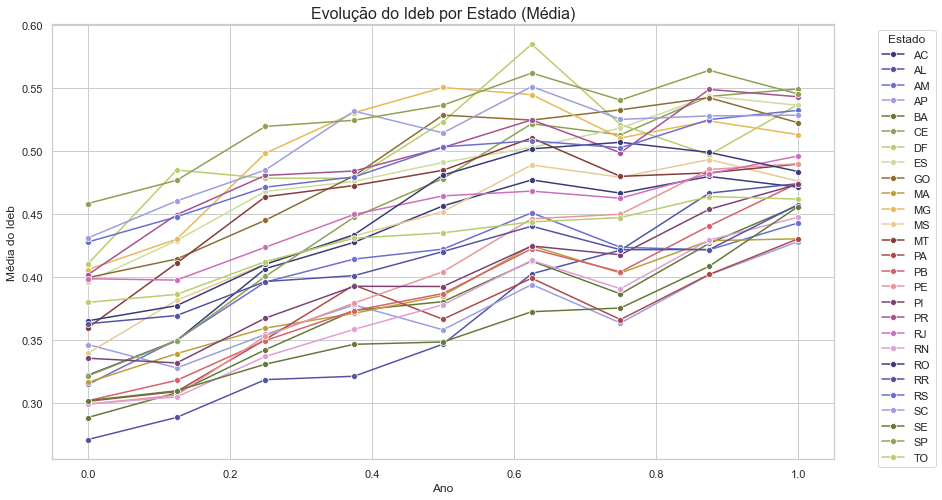

In [46]:
# Agrupando os dados por ano e UF para calcular a m√©dia do Ideb
ideb_por_ano_regiao = df.groupby(['ano', 'sigla_uf'])['ideb'].mean().reset_index()

# Gr√°fico de linhas mostrando a evolu√ß√£o do Ideb por estado ao longo dos anos
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=ideb_por_ano_regiao,
    x='ano', y='ideb', hue='sigla_uf',
    palette='tab20b', marker='o'  # Ou palette='tab20c'
)
plt.title('Evolu√ß√£o do Ideb por Estado (M√©dia)', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('M√©dia do Ideb', fontsize=12)
plt.legend(title='Estado', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Resultado da Analise:**

#### 2. An√°lise de Correla√ß√£o

Objetivo: Identificar rela√ß√µes entre as vari√°veis num√©ricas, como notas do Saeb, taxa de aprova√ß√£o e Ideb.

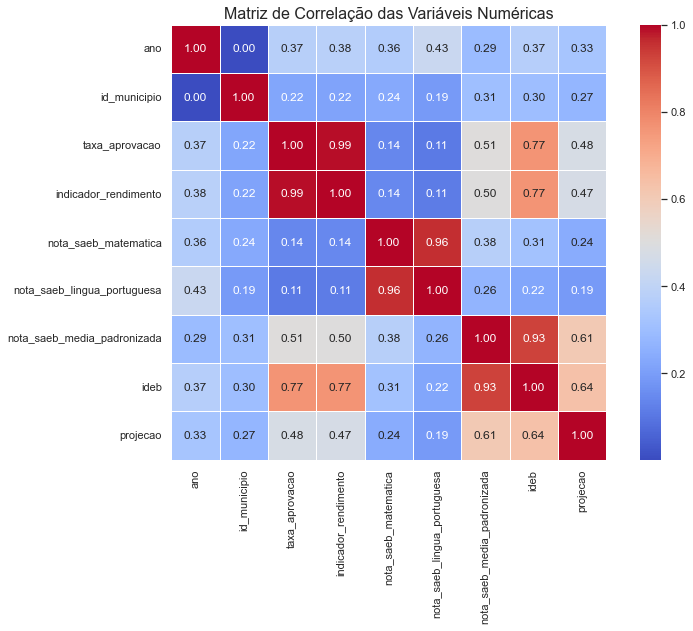

In [47]:
# Seleciona apenas as colunas num√©ricas para c√°lculo da correla√ß√£o
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_columns].corr()

# Visualizando a matriz de correla√ß√£o como um heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
    square=True, linewidths=0.5
)
plt.title('Matriz de Correla√ß√£o das Vari√°veis Num√©ricas', fontsize=16)
plt.show()



**Resultado da Analise:**

#### 3. Distribui√ß√£o de Notas do Saeb

Objetivo: Analisar a distribui√ß√£o das notas padronizadas do Saeb (Sistema de Avalia√ß√£o da Educa√ß√£o B√°sica) entre diferentes redes de ensino no Brasil (estadual, p√∫blica, federal e municipal). Essa an√°lise visa identificar padr√µes e poss√≠veis diferen√ßas no desempenho dos alunos, fornecendo insights sobre a qualidade do ensino em cada tipo de rede.

/tmp/ipykernel_1826232/1371815608.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_1826232/1371815608.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


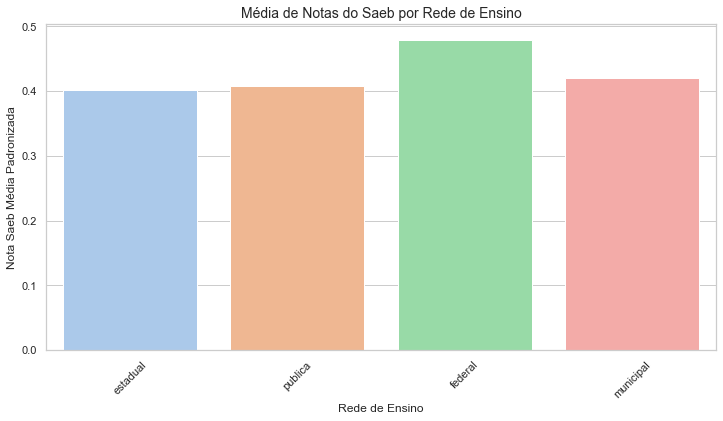

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_normalized,
    x='rede',
    y='nota_saeb_media_padronizada',
    palette="pastel",
    ci=None  # Remove as barras de erro
)
plt.title('M√©dia de Notas do Saeb por Rede de Ensino', fontsize=14)
plt.xlabel('Rede de Ensino', fontsize=12)
plt.ylabel('Nota Saeb M√©dia Padronizada', fontsize=12)
plt.xticks(rotation=45)
plt.show()

**Resultado da Analise:**

1. Eixo X (Rede de Ensino):

    - Representa os diferentes tipos de redes de ensino: estadual, p√∫blica, federal e municipal.

2. Eixo Y (Nota Saeb M√©dia Padronizada):
    - Indica as notas m√©dias padronizadas no Saeb, que variam de 0 a 1.

3. Boxplot:
    - Linha horizontal dentro da caixa: Representa a mediana das notas para cada rede de ensino.
    - Caixa: Mostra o intervalo interquartil (IQR), ou seja, as notas entre o 25¬∫ e o 75¬∫ percentil.
    - Linhas verticais (whiskers): Indicam o alcance das notas sem considerar os outliers.

4. Violinplot (Fundo cinza):
    - Representa a densidade das notas, indicando onde os dados est√£o mais concentrados.
    - Parte mais larga: Indica maior concentra√ß√£o de valores em determinado intervalo.
    - Parte mais estreita: Indica menor concentra√ß√£o de valores.

#### üìä 4. Distribui√ß√£o das Notas do Saeb

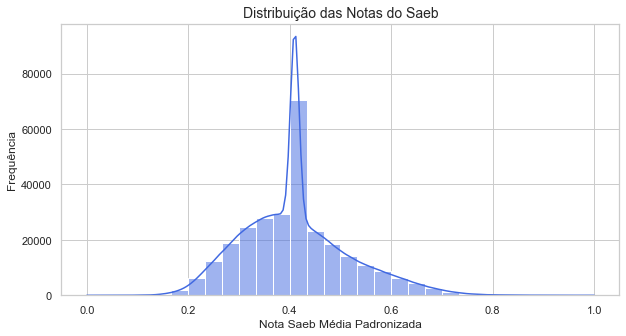

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(df_normalized['nota_saeb_media_padronizada'], bins=30, kde=True, color='royalblue')
plt.title('Distribui√ß√£o das Notas do Saeb', fontsize=14)
plt.xlabel('Nota Saeb M√©dia Padronizada', fontsize=12)
plt.ylabel('Frequ√™ncia', fontsize=12)
plt.show()


#### üî• 5. Correla√ß√£o entre as Vari√°veis (Heatmap)



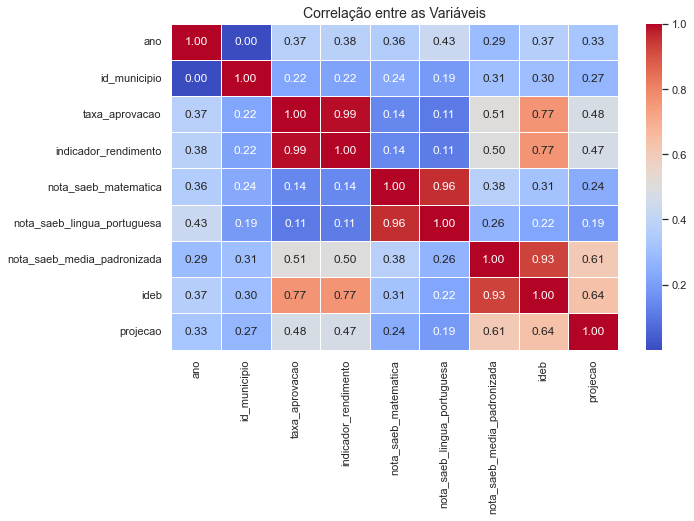

In [50]:
# Selecionar apenas colunas num√©ricas
df_corr = df_normalized.select_dtypes(include=['float64', 'int64'])

# Criar o heatmap sem erros
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correla√ß√£o entre as Vari√°veis', fontsize=14)
plt.show()


#### üè´ 6. Compara√ß√£o do IDEB por Rede de Ensino

/tmp/ipykernel_1826232/1045417185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


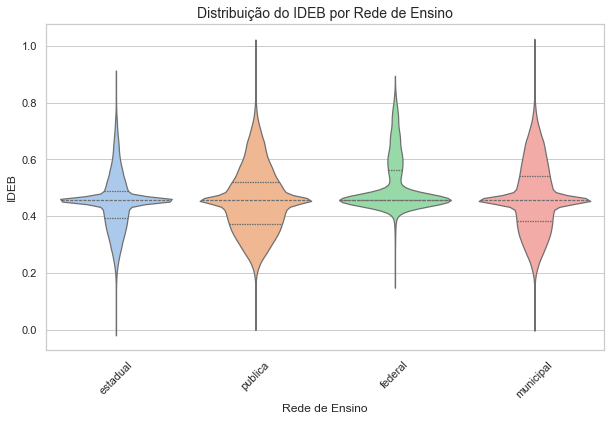

In [51]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_normalized, 
    x='rede', 
    y='ideb', 
    inner="quartile", 
    palette="pastel"
)
plt.title('Distribui√ß√£o do IDEB por Rede de Ensino', fontsize=14)
plt.xlabel('Rede de Ensino', fontsize=12)
plt.ylabel('IDEB', fontsize=12)
plt.xticks(rotation=45)
plt.show()


#### üìà 7. Rela√ß√£o entre Taxa de Aprova√ß√£o e Nota do Saeb

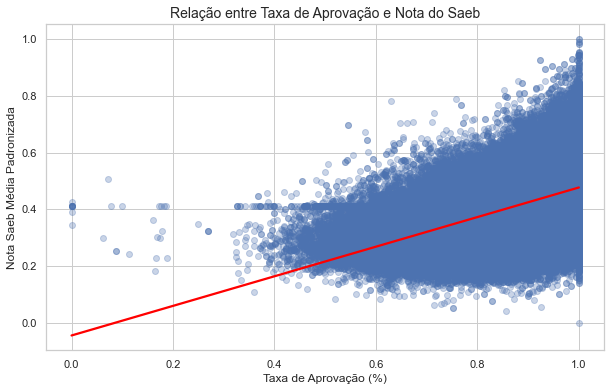

In [52]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_normalized, 
    x="taxa_aprovacao", 
    y="nota_saeb_media_padronizada", 
    scatter_kws={"alpha": 0.3}, 
    line_kws={"color": "red"}, 
    ci=None
)
plt.title("Rela√ß√£o entre Taxa de Aprova√ß√£o e Nota do Saeb", fontsize=14)
plt.xlabel("Taxa de Aprova√ß√£o (%)", fontsize=12)
plt.ylabel("Nota Saeb M√©dia Padronizada", fontsize=12)
plt.show()


#### üåé 8. Distribui√ß√£o das Notas do Saeb por Estado

/tmp/ipykernel_1826232/741029034.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sigla_uf', y='nota_saeb_media_padronizada', data=state_means, palette="Set2")


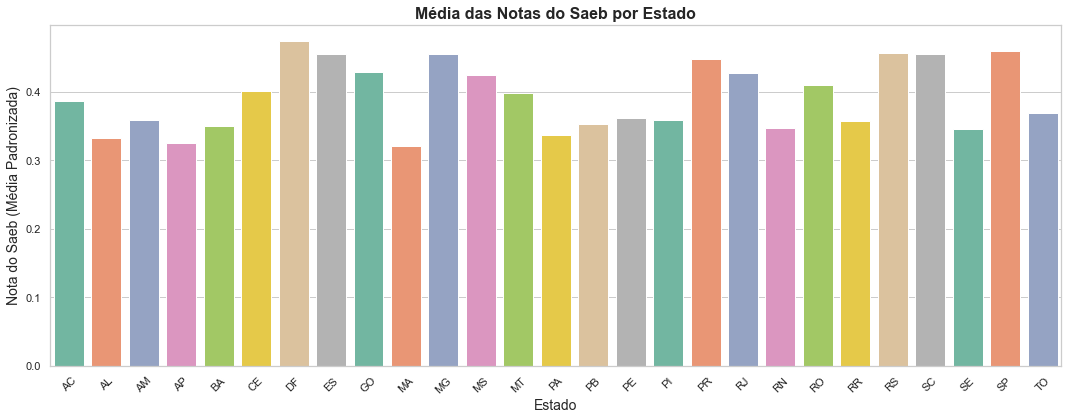

In [53]:


# Ajuste do gr√°fico de barras (m√©dia)
plt.figure(figsize=(15, 6))

# Calcular a m√©dia por estado
state_means = df_normalized.groupby('sigla_uf')['nota_saeb_media_padronizada'].mean().reset_index()

# Gr√°fico de barras com a m√©dia das notas por estado
sns.barplot(x='sigla_uf', y='nota_saeb_media_padronizada', data=state_means, palette="Set2")

# T√≠tulo e r√≥tulos
plt.title('M√©dia das Notas do Saeb por Estado', fontsize=16, weight='bold')
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Nota do Saeb (M√©dia Padronizada)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### 9. Distribui√ß√£o das vari√°veis num√©ricas


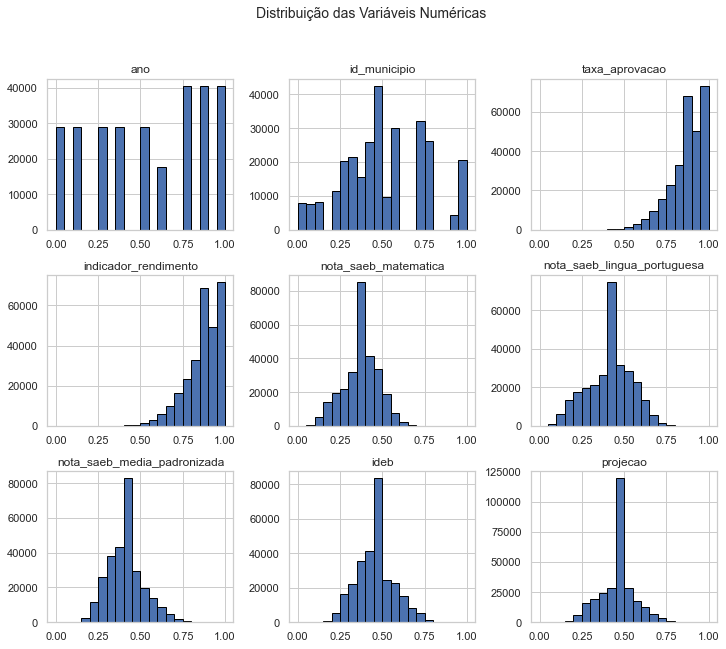

In [54]:
numerical_columns = df_normalized.select_dtypes(include=['float64', 'int64']).columns

df_normalized[numerical_columns].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Distribui√ß√£o das Vari√°veis Num√©ricas", fontsize=14)
plt.show()


#### 10. Evolu√ß√£o do IDEB ao longo dos anos

/tmp/ipykernel_1826232/2511231987.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


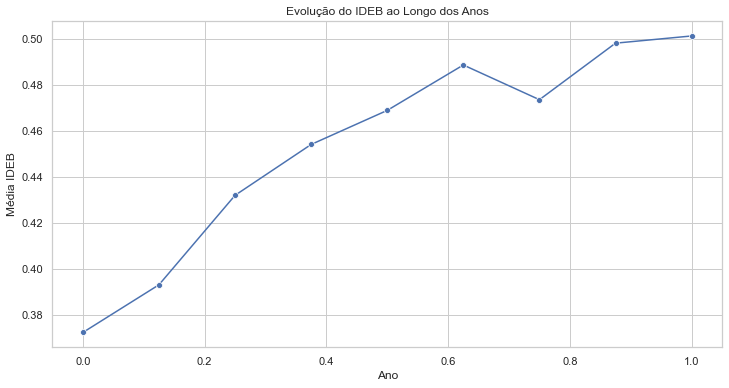

In [55]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_normalized,
    x='ano',
    y='ideb',
    estimator=np.mean,
    ci=None,
    marker="o",
    color="b"
)
plt.title("Evolu√ß√£o do IDEB ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("M√©dia IDEB")
plt.grid(True)
plt.show()

## Feature Engineering 

### üöÄ Transforma√ß√µes e Cria√ß√£o de Vari√°veis para Melhorar o Modelo

#### üìå Vari√°vel "diferenca_ideb_projecao"

- A vari√°vel √© o calcualo da diferen√ßa entre o **IDEB** observado e sua **proje√ß√£o**. indicand se o munic√≠pio atingiu ou superou a meta esperada

In [56]:
df['diferenca_ideb_projecao'] = df['ideb'] - df['projecao']


### üìå M√©trica M√©dia das Notas SAEB
- M√©dia simples das notas de matem√°tica e lingua portuguesa, para capturar o desempenho geral dos estudantes sem a padroniza√ß√£o

In [57]:
df['nota_saeb_media'] = (df['nota_saeb_matematica'] + df['nota_saeb_lingua_portuguesa']) / 2


### üìå Normaliza√ß√£o da Taxa de Aprova√ß√£o
- Padronziar a `taxa_aprovacao`entre 0 e 1 para possibilitar compara√ß√µes mais eficazes

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['taxa_aprovacao_normalizada'] = scaler.fit_transform(df[['taxa_aprovacao']])


### üìå Cria√ß√£o de um Agrupamento por Regi√µes
- Associamos os estados √†s regi√µes brasileiras para capturar padr√µes geogr√°ficos.

In [59]:
regiao_map = {
    'Norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

def map_regiao(estado):
    for regiao, estados in regiao_map.items():
        if estado in estados:
            return regiao
    return 'Desconhecido'

df['regiao'] = df['sigla_uf'].apply(map_regiao)


### üìå Convers√£o do Ano para Vari√°vel Num√©rica


- Convertendo ano para formato num√©rico para facilitar an√°lise temporal.

In [60]:
df['ano'] = df['ano'].astype(int)


## Modelagem e Avalia√ß√£o do IDEB


### 1. Defini√ß√£o das Vari√°veis e Prepara√ß√£o dos Dados

In [61]:
# Definir as vari√°veis preditoras (X) e a vari√°vel alvo (y)
X = df_normalized.drop(columns=['ideb', 'sigla_uf', 'rede', 'ensino', 'anos_escolares'])  # Removemos colunas categ√≥ricas
y = df_normalized['ideb']

# Dividir os dados em conjunto de treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Sele√ß√£o de Vari√°veis com Random Forest

In [62]:
# Criando o modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Criando um DataFrame para visualizar a import√¢ncia das vari√°veis
feature_importances = pd.DataFrame({'Vari√°vel': X.columns, 'Import√¢ncia': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Import√¢ncia', ascending=False)

# Exibindo a tabela de import√¢ncias
print("Tabela de Import√¢ncia das Vari√°veis:")
print(feature_importances)

Tabela de Import√¢ncia das Vari√°veis:
                      Vari√°vel  Import√¢ncia
6  nota_saeb_media_padronizada     0.845344
3         indicador_rendimento     0.154176
2               taxa_aprovacao     0.000349
5  nota_saeb_lingua_portuguesa     0.000039
4         nota_saeb_matematica     0.000036
1                 id_municipio     0.000025
7                     projecao     0.000019
0                          ano     0.000012


A sele√ß√£o de vari√°veis utilizando o Random Forest indicou que a nota_saeb_media_padronizada √© a vari√°vel mais influente na previs√£o do IDEB, com uma import√¢ncia de 0.845344. Em seguida, o indicador_rendimento teve uma relev√¢ncia consider√°vel (0.154176), enquanto outras vari√°veis, como taxa_aprovacao e nota_saeb_matematica, apresentaram valores insignificantes.

### 3. Visualiza√ß√£o da Import√¢ncia das Vari√°veis

/tmp/ipykernel_1826232/2056543730.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Import√¢ncia', y='Vari√°vel', data=feature_importances, palette="viridis")


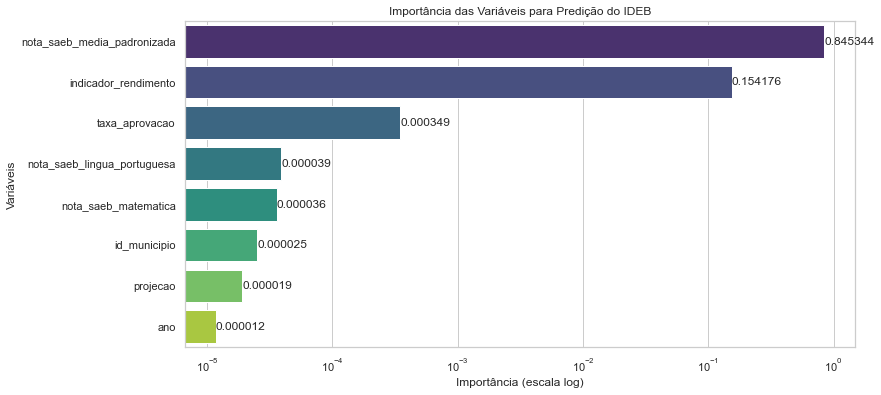

In [63]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Import√¢ncia', y='Vari√°vel', data=feature_importances, palette="viridis")

plt.xscale("log")  # Ajustando escala se necess√°rio

for index, value in enumerate(feature_importances["Import√¢ncia"]):
    plt.text(value, index, f'{value:.6f}', va='center')

plt.title("Import√¢ncia das Vari√°veis para Predi√ß√£o do IDEB")
plt.xlabel("Import√¢ncia (escala log)")
plt.ylabel("Vari√°veis")
plt.show()

**Principais Observa√ß√µes**

- Vari√°vel mais importante:
   - `A nota_saeb_media_padronizada` se destaca amplamente como a vari√°vel mais influente, com um valor de import√¢ncia de 0.845344. Isso refor√ßa a correla√ß√£o direta entre o desempenho dos alunos no Saeb e a nota do IDEB.

- Segunda vari√°vel mais relevante:
    - O indicador_rendimento tem uma import√¢ncia consider√°vel (0.154176), sugerindo que fatores relacionados ao desempenho acad√™mico e √† perman√™ncia dos alunos na escola s√£o determinantes para a previs√£o do IDEB.

- Vari√°veis secund√°rias:
    - A taxa_aprovacao aparece em terceiro lugar, por√©m, com um valor de import√¢ncia significativamente menor (0.000349).

    - nota_saeb_lingua_portuguesa e nota_saeb_matematica aparecem com valores pr√≥ximos (0.000039 e 0.000036, respectivamente), indicando que, apesar de terem influ√™ncia, sua - relev√¢ncia √© menor quando comparada √† m√©dia geral do Saeb.

    - Outras vari√°veis como id_municipio, projecao e ano possuem impactos ainda mais reduzidos.

**Interpreta√ß√£o**

- A grande discrep√¢ncia entre as duas primeiras vari√°veis e as demais refor√ßa a ideia de que o IDEB est√° fortemente ligado √† m√©dia padronizada do Saeb e ao rendimento dos alunos.

- O uso da escala logar√≠tmica permite uma melhor visualiza√ß√£o dessas diferen√ßas, especialmente para as vari√°veis de menor impacto.

- A baixa import√¢ncia de vari√°veis como ano e id_municipio indica que as caracter√≠sticas temporais e geogr√°ficas espec√≠ficas n√£o afetam significativamente a predi√ß√£o do IDEB, refor√ßando o peso dos indicadores educacionais.

**Implica√ß√µes**

- Foco em avalia√ß√µes do Saeb: Melhorar o desempenho dos alunos nessas avalia√ß√µes pode ser a estrat√©gia mais eficaz para aumentar o IDEB.

- Aten√ß√£o √† taxa de rendimento: Pol√≠ticas para reduzir a evas√£o e garantir a aprova√ß√£o dos estudantes podem impactar positivamente os resultados educacionais.

- Modelagem aprimorada: Como poucas vari√°veis apresentam relev√¢ncia significativa, um modelo mais enxuto e otimizado pode ser utilizado para prever o IDEB com alta precis√£o.

### 4. Sele√ß√£o de Vari√°veis com Recursive Feature Elimination (RFE)

In [64]:
from sklearn.feature_selection import RFE

model_rfe = LinearRegression()
rfe = RFE(model_rfe, n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Vari√°veis Selecionadas pelo RFE:", selected_features)

Vari√°veis Selecionadas pelo RFE: Index(['taxa_aprovacao', 'indicador_rendimento', 'nota_saeb_matematica',
       'nota_saeb_media_padronizada', 'projecao'],
      dtype='object')


O m√©todo Recursive Feature Elimination (RFE) selecionou cinco vari√°veis principais: taxa_aprovacao, indicador_rendimento, nota_saeb_matematica, nota_saeb_media_padronizada e projecao. Isso refor√ßa a influ√™ncia da taxa de aprova√ß√£o e da m√©dia padronizada do Saeb na previs√£o do IDEB.

### 5. Cria√ß√£o e Avalia√ß√£o dos Modelos de Machine Learning

In [65]:
# Definindo as vari√°veis com base na sele√ß√£o anterior
X = df_normalized[selected_features]
y = df_normalized['ideb']

# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializando os modelos
models = {
    "Regress√£o Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "√Årvore de Decis√£o": DecisionTreeRegressor(random_state=42)
}

# Dicion√°rio para armazenar os resultados
results = {"Modelo": [], "R¬≤": [], "RMSE": [], "MAE": []}

# Treinando e avaliando cada modelo
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculando m√©tricas
    results["Modelo"].append(model_name)
    results["R¬≤"].append(r2_score(y_test, y_pred))
    results["RMSE"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    results["MAE"].append(mean_absolute_error(y_test, y_pred))

# Convertendo para DataFrame
results_df = pd.DataFrame(results)
print(results_df)

              Modelo        R¬≤      RMSE       MAE
0   Regress√£o Linear  0.981350  0.015064  0.008513
1      Random Forest  0.999804  0.001544  0.000557
2            XGBoost  0.998681  0.004007  0.002643
3  √Årvore de Decis√£o  0.999620  0.002151  0.000383


Interpreta√ß√£o dos Resultados

- Random Forest e √Årvore de Decis√£o demonstraram um desempenho excelente, com valores de R¬≤ acima de 0.999, baixos RMSE e MAE. Isso sugere que esses modelos s√£o altamente eficazes na previs√£o do IDEB.

- XGBoost tamb√©m apresentou um bom desempenho, mas ficou levemente atr√°s do Random Forest.

- Regress√£o Linear teve um desempenho inferior, com um R¬≤ de 0.981350, indicando que n√£o captura t√£o bem a complexidade dos dados quanto os modelos baseados em √°rvores.

### 6. Compara√ß√£o dos Modelos

/tmp/ipykernel_1826232/2809240353.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R¬≤", y="Modelo", data=results_df, palette="viridis")


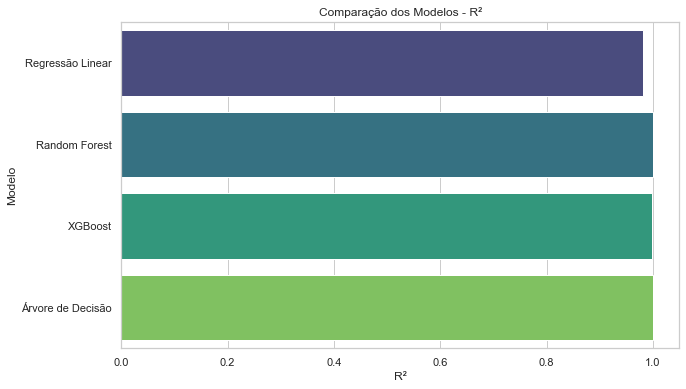

/tmp/ipykernel_1826232/2809240353.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RMSE", y="Modelo", data=results_df, palette="viridis")


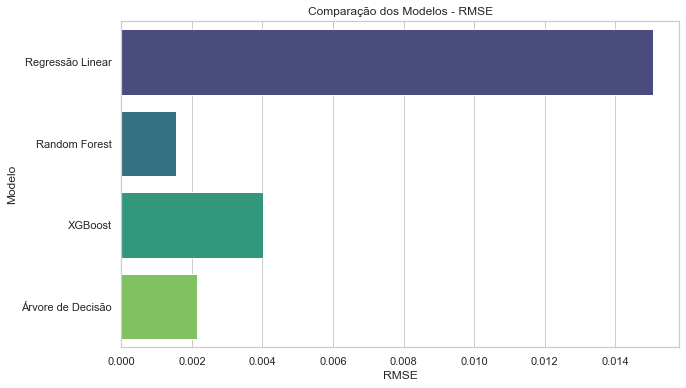

/tmp/ipykernel_1826232/2809240353.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MAE", y="Modelo", data=results_df, palette="viridis")


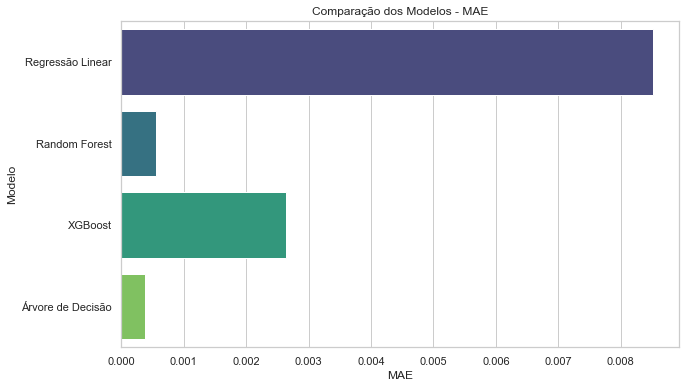

In [66]:
# Visualizando as m√©tricas para comparar os modelos
plt.figure(figsize=(10, 6))
sns.barplot(x="R¬≤", y="Modelo", data=results_df, palette="viridis")
plt.title("Compara√ß√£o dos Modelos - R¬≤")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="RMSE", y="Modelo", data=results_df, palette="viridis")
plt.title("Compara√ß√£o dos Modelos - RMSE")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="MAE", y="Modelo", data=results_df, palette="viridis")
plt.title("Compara√ß√£o dos Modelos - MAE")
plt.show()

Conclus√£o e Implica√ß√µes

Os resultados indicam que a nota_saeb_media_padronizada √© o principal fator determinante do IDEB nos munic√≠pios brasileiros. Isso sugere que melhorias na qualidade da educa√ß√£o, refletidas pelo desempenho dos alunos no Saeb, podem impactar diretamente o IDEB.

üìä Quais vari√°veis influenciam a previs√£o?

A an√°lise mostrou que as vari√°veis mais importantes para prever o IDEB s√£o:

1. nota_saeb_media_padronizada ‚Üí Desempenho m√©dio dos alunos no Saeb (MAIOR IMPACTO)

2. indicador_rendimento ‚Üí Mede o fluxo escolar (aprova√ß√£o, reprova√ß√£o, abandono)

3. taxa_aprovacao ‚Üí Percentual de alunos aprovados

4. nota_saeb_lingua_portuguesa ‚Üí Nota dos alunos em l√≠ngua portuguesa

5. nota_saeb_matematica ‚Üí Nota dos alunos em matem√°tica

6. projecao ‚Üí Expectativa de crescimento do IDEB

7. ano e id_municipio ‚Üí Identificadores auxiliares


O modelo Random Forest se destacou como a melhor op√ß√£o para previs√£o, com alta precis√£o e baixo erro.

**Recomenda√ß√µes:**

- Foco no desempenho Saeb: Como a nota padronizada do Saeb √© a vari√°vel mais influente, estrat√©gias para melhorar esse desempenho devem ser priorizadas.

- Investimento na perman√™ncia escolar: O indicador de rendimento tamb√©m se mostrou relevante, indicando que taxas de aprova√ß√£o e fluxo escolar impactam o IDEB.

- Uso do Random Forest: Para previs√£o futura do IDEB, esse modelo √© altamente recomendado devido √† sua precis√£o.

**üèÜ Por que isso √© √∫til?**

‚úî Permite prever o desempenho educacional futuro com base em dados hist√≥ricos.

‚úî Ajuda na tomada de decis√µes para melhorar o IDEB, indicando quais fatores s√£o mais importantes.

‚úî Auxilia na cria√ß√£o de pol√≠ticas p√∫blicas focadas em melhorar os fatores que mais impactam o √≠ndice.


Ou seja, o Random Forest est√° prevendo qual ser√° o IDEB de um munic√≠pio ou escola, usando como base fatores como notas dos alunos, taxa de aprova√ß√£o e rendimento escolar. üöÄ

Com base nesses insights, gestores p√∫blicos podem elaborar pol√≠ticas mais eficazes para a melhoria da educa√ß√£o nos munic√≠pios brasileiros.

